In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [2]:
#Import data
data = pd.read_csv('/Users/cr24/Desktop/Data Science Assignment/Assignment.csv')

# transform the column names to lowercase
data.columns = data.columns.str.lower()
data = data.rename(columns= {'duree': 'expo','nbrtotan': 'freq','nbrtotc': 'nclaims'})
data = data.drop(['lnexpo','codposs','chargtot','sexp','split'],axis=1)


In [3]:
data.head(100)

,ageph,expo,nclaims,freq,agecar,fuelc,usec,fleetc,sportc,coverp,powerc
0,64,1.000000,0,0.000000,2-5,Petrol,Private,No,No,MTPL+,66-110
1,28,0.046575,1,21.470588,6-10,Petrol,Private,No,No,MTPL,66-110
2,58,0.402740,0,0.000000,>10,Petrol,Private,No,No,MTPL,<66
3,37,0.169863,0,0.000000,2-5,Petrol,Professional,No,No,MTPL+++,66-110
4,29,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL+,<66
...,...,...,...,...,...,...,...,...,...,...,...
95,49,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL+,<66
96,28,1.000000,0,0.000000,2-5,Petrol,Private,Yes,No,MTPL+++,66-110
97,29,1.000000,0,0.000000,6-10,Petrol,Private,No,No,MTPL,66-110
98,31,0.301370,2,6.636364,>10,Petrol,Private,No,No,MTPL,66-110


In [4]:
# List of categorical variables
categorical_variables = ['agecar', 'fuelc', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']

# Encoding categorical variables one by one
pd.options.mode.copy_on_write = True
label_encoders = {}
for var in categorical_variables:
    label_encoders[var] = LabelEncoder()
    data[var] = label_encoders[var].fit_transform(data[var])

In [5]:
data.head(100)

,ageph,expo,nclaims,freq,agecar,fuelc,usec,fleetc,sportc,coverp,powerc
0,64,1.000000,0,0.000000,1,1,0,0,0,1,0
1,28,0.046575,1,21.470588,2,1,0,0,0,0,0
2,58,0.402740,0,0.000000,3,1,0,0,0,0,1
3,37,0.169863,0,0.000000,1,1,1,0,0,2,0
4,29,1.000000,0,0.000000,2,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
95,49,1.000000,0,0.000000,2,1,0,0,0,1,1
96,28,1.000000,0,0.000000,1,1,0,1,0,2,0
97,29,1.000000,0,0.000000,2,1,0,0,0,0,0
98,31,0.301370,2,6.636364,3,1,0,0,0,0,0


In [6]:
data.dtypes

ageph        int64
expo       float64
nclaims      int64
freq       float64
agecar       int64
fuelc        int64
usec         int64
fleetc       int64
sportc       int64
coverp       int64
powerc       int64
dtype: object

In [7]:
# Features
columns_all = ['expo','ageph','agecar','fuelc','usec','fleetc','sportc','coverp','powerc']
x = data[columns_all]

# Frequency
y = np.array(data['freq'])



In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
columns = ['ageph','agecar','fuelc','usec','fleetc','sportc','coverp','powerc']
expo_train = X_train['expo']
X_train = X_train[columns]
expo_test = X_test['expo']
X_test = X_test[columns]


In [10]:
# initialize a tree of depth 2
tree_freq = DecisionTreeRegressor(criterion='poisson', min_samples_split=100, min_samples_leaf=1000)
# fit the tree to our target with weights
tree_freq.fit(X=X_train, y=y_train, sample_weight=expo_train)
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', min_samples_leaf=1000,
                      min_samples_split=100)

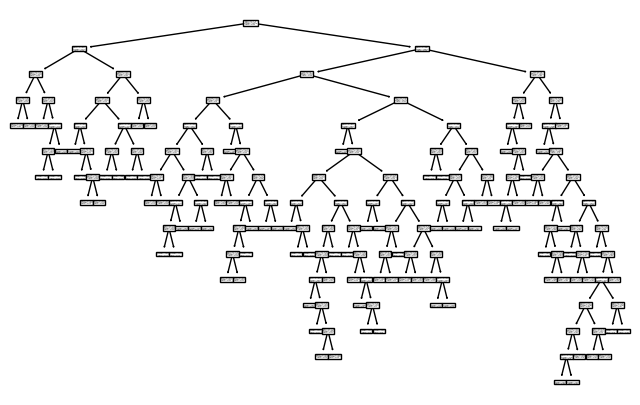

In [11]:
# plot the tree structure
plt.figure(figsize=(8, 5), dpi=100)
plot_tree(tree_freq, feature_names=columns);

In [12]:
y_pred = tree_freq.predict(X_train)
MSE_train = mean_squared_error(y_train,y_pred, sample_weight=expo_train)
print('MSE for training data:', MSE_train)

y_pred_test = tree_freq.predict(X_test)
MSE_test = mean_squared_error(y_test,y_pred_test, sample_weight=expo_test)
print('MSE for test data:', MSE_test)

MSE for training data: 0.19047413968768118
MSE for test data: 0.19287575207106014


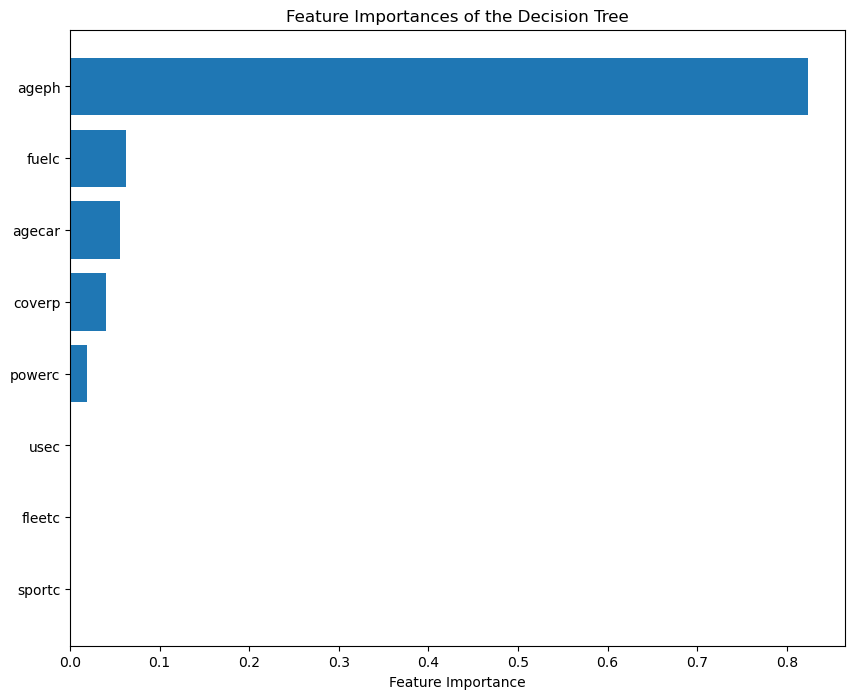

In [13]:
feature_importances = pd.Series(tree_freq.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_importances.index, sorted_feature_importances.values)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of the Decision Tree')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

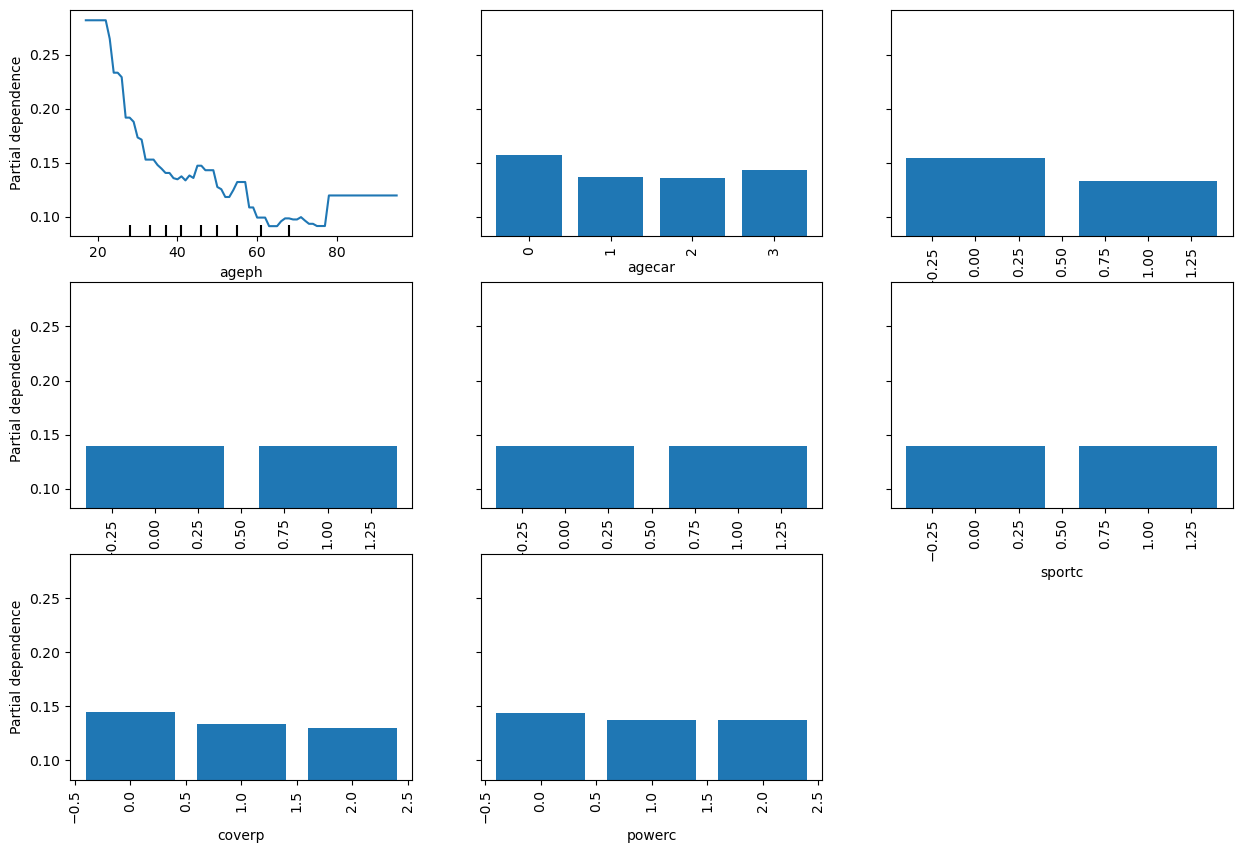

In [14]:
# create pdps for a couple of features
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(tree_freq, X_train, features = columns, categorical_features=categorical_variables, kind='average', ax=ax);

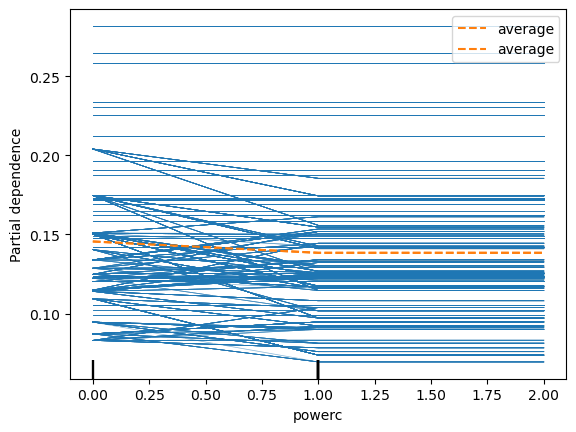

In [23]:
# Compute partial dependence plots and individual conditional expectation
ice = ['powerc']
display = PartialDependenceDisplay.from_estimator(tree_freq, X_train, features=ice, kind='both')
display.plot(ax=display.axes_)


(1, 130925, 3)

<Figure size 800x400 with 0 Axes>

In [105]:

ice = partial_dependence(tree_freq,X_train,features=['powerc'], kind='individual',percentiles=(0,1),grid_resolution=5)
np.shape(ice['individual'])

for i in range(0,len(X_train)):
    ice_start = ice['individual'][0][i][0]
    ice['individual'][0][i]=ice['individual'][0][i] - ice_start

color_feature = 'ageph'
colors = ['tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(12,8))
age_0_25 = []
age_25_50 = []
age_50_75 = []
age_75_100 = []

for i in range(len(X_train)):
    age = X_train['ageph'].iloc[i]
    if age > 0 and age <= 25:
        age_0_25.append(ice['individual'][0][i])
    elif age > 25 and age <= 50:
        age_25_50.append(ice['individual'][0][i])
    elif age > 50 and age <= 75:
        age_50_75.append(ice['individual'][0][i])
    else:
        age_75_100.append(ice['individual'][0][i])


age_0_25 = pd.DataFrame(age_0_25).mean()
age_25_50 = pd.DataFrame(age_25_50).mean()
age_50_75 = pd.DataFrame(age_50_75).mean()
age_75_100 = pd.DataFrame(age_75_100).mean()

df = pd.DataFrame(index=range(3), columns=range(4))
df.iloc[:,0]= age_0_25
df.iloc[:,1] = age_25_50
df.iloc[:,2]= age_50_75
df.iloc[:,3]= age_75_100



<Figure size 1200x800 with 0 Axes>

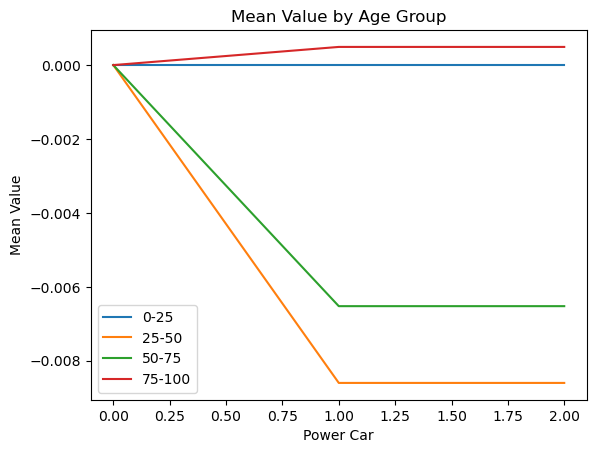

In [106]:
label = ['0-25','25-50','50-75','75-100']
# Plot the DataFrame
for i in range(4):
    plt.plot(df.index, df[i], label=label[i])
# Add labels and legend
plt.xlabel('Power Car')
plt.ylabel('Mean Value')
plt.title('Mean Value by Age Group')
plt.legend()


In [107]:

ice = partial_dependence(tree_freq,X_train,features=['coverp'], kind='individual',percentiles=(0,1),grid_resolution=5)
np.shape(ice['individual'])


for i in range(0,len(X_train)):
    ice_start = ice['individual'][0][i][0]
    ice['individual'][0][i]=ice['individual'][0][i] - ice_start

    
color_feature = 'ageph'
colors = ['tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(12,8))
age_0_25 = []
age_25_50 = []
age_50_75 = []
age_75_100 = []

for i in range(len(X_train)):
    age = X_train['ageph'].iloc[i]
    if age > 0 and age <= 25:
        age_0_25.append(ice['individual'][0][i])
    elif age > 25 and age <= 50:
        age_25_50.append(ice['individual'][0][i])
    elif age > 50 and age <= 75:
        age_50_75.append(ice['individual'][0][i])
    else:
        age_75_100.append(ice['individual'][0][i])


age_0_25 = pd.DataFrame(age_0_25).mean()
age_25_50 = pd.DataFrame(age_25_50).mean()
age_50_75 = pd.DataFrame(age_50_75).mean()
age_75_100 = pd.DataFrame(age_75_100).mean()

df = pd.DataFrame(index=range(3), columns=range(4))
df.iloc[:,0]= age_0_25
df.iloc[:,1] = age_25_50
df.iloc[:,2]= age_50_75
df.iloc[:,3]= age_75_100

df

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,-0.016714,-0.014241,-0.004912,-0.000796
2,-0.016714,-0.019251,-0.007965,-0.002308


<Figure size 1200x800 with 0 Axes>

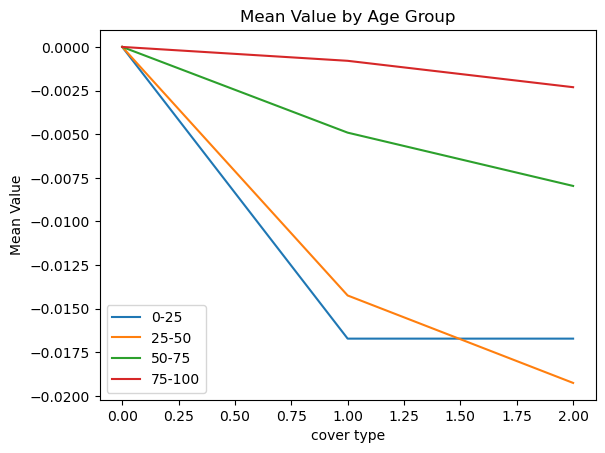

In [108]:
label = ['0-25','25-50','50-75','75-100']
# Plot the DataFrame
for i in range(4):
    plt.plot(df.index, df[i], label=label[i])
# Add labels and legend
plt.xlabel('cover type')
plt.ylabel('Mean Value')
plt.title('Mean Value by Age Group')
plt.legend()


In [ ]:

ice = partial_dependence(tree_freq,X_train,features=['coverp'], kind='individual',percentiles=(0,1),grid_resolution=5)
np.shape(ice['individual'])

color_feature = 'ageph'
colors = ['tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(12,8))
age_0_25 = []
age_25_50 = []
age_50_75 = []
age_75_100 = []

for i in range(len(X_train)):
    age = X_train['ageph'].iloc[i]
    if age > 0 and age <= 25:
        age_0_25.append(ice['individual'][0][i])
    elif age > 25 and age <= 50:
        age_25_50.append(ice['individual'][0][i])
    elif age > 50 and age <= 75:
        age_50_75.append(ice['individual'][0][i])
    else:
        age_75_100.append(ice['individual'][0][i])


age_0_25 = pd.DataFrame(age_0_25).mean()
age_25_50 = pd.DataFrame(age_25_50).mean()
age_50_75 = pd.DataFrame(age_50_75).mean()
age_75_100 = pd.DataFrame(age_75_100).mean()

df = pd.DataFrame(index=range(3), columns=range(4))
df.iloc[:,0]= age_0_25
df.iloc[:,1] = age_25_50
df.iloc[:,2]= age_50_75
df.iloc[:,3]= age_75_100

df

In [ ]:
label = ['0-25','25-50','50-75','75-100']
# Plot the DataFrame
for i in range(4):
    plt.plot(df.index, df[i], label=label[i])
# Add labels and legend
plt.xlabel('cover type')
plt.ylabel('Mean Value')
plt.title('Mean Value by Age Group')
plt.legend()
